In [1]:
import zipfile 
import pysal as ps
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
import gzip
import mapreduce as mr
import csv
import networkx as nx #library supporting networks

### Change reduced area

In [2]:
fname = 'Data/CensusTracks.geojson'
tracks = gpd.GeoDataFrame.from_file(fname)
validCT = set(tracks[tracks.Within30min == True].boro_ct_2010)

In [3]:
fname = 'Data/Reducedtrack.geojson'
reduced = gpd.GeoDataFrame.from_file(fname)
reducedct = set(reduced[reduced.bigManhattanCommute == True].boro_ct_2010)

In [4]:
def maptracks(row):
    if row['h_track'] in validCT:
        if ((row['h_track'][0]=='3')|(row['h_track'][0]=='4')):
            #print 'yes'
            if row['w_track'][0]=='1':
                #print 'yes'
                yield (row['w_track'], row['h_track'],int(row['S000']))

def reducehtracks(counts, pair_int):
    pair=pair_int[0:2]
    counts[pair] = counts.get(pair, 0)+pair_int[-1]
    return counts

with open('Data/True_nyod_JT00thegood_2014.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    output2 = sorted(reduce(reducehtracks,list(mr.run(reader,maptracks)), {}).items())
    #
print len(output2)
output2[:10]

33609


[(('1000100', '3029700'), 2),
 (('1000100', '3030700'), 1),
 (('1000100', '3037700'), 1),
 (('1000100', '3038100'), 2),
 (('1000100', '3089400'), 1),
 (('1000100', '3090000'), 3),
 (('1000100', '3098200'), 1),
 (('1000100', '3098400'), 3),
 (('1000100', '3113000'), 2),
 (('1000100', '3114400'), 1)]

In [5]:
def maptracks2(row):
    yield row[0][0], row[0][1], row[1],


def reducehtracks(pair_int):
 
    return pair_int[0],pair_int[1],pair_int[2],

output3 = list(mr.run(output2,maptracks2))#,reducehtracks))
    #
print len(output3)
output3[:15]

33609


[('1000100', '3029700', 2),
 ('1000100', '3030700', 1),
 ('1000100', '3037700', 1),
 ('1000100', '3038100', 2),
 ('1000100', '3089400', 1),
 ('1000100', '3090000', 3),
 ('1000100', '3098200', 1),
 ('1000100', '3098400', 3),
 ('1000100', '3113000', 2),
 ('1000100', '3114400', 1),
 ('1000100', '3117202', 3),
 ('1000100', '4055900', 1),
 ('1000100', '4056100', 1),
 ('1000201', '3000100', 1),
 ('1000201', '3025300', 1)]

In [6]:
G=nx.Graph()

In [7]:
for i in output3:
    #print i
    if len(i)==3:
        if i[1] in reducedct:
            G.add_weighted_edges_from([i])
#print G.edges()
#G.edges(data=True)[:10]

In [8]:
trackcent = tracks

In [9]:
trackcent['centroid'] = trackcent.geometry.centroid

In [10]:
d = G.degree(weight='weight')

In [11]:
max(G.degree(weight='weight').values())

2149

In [12]:
G.degree(weight='weight')

{'1000100': 2,
 '1000201': 9,
 '1000202': 33,
 '1000500': 5,
 '1000600': 83,
 '1000700': 1261,
 '1000800': 75,
 '1000900': 1411,
 '1001001': 1,
 '1001002': 21,
 '1001200': 12,
 '1001300': 1079,
 '1001401': 29,
 '1001402': 69,
 '1001501': 293,
 '1001502': 698,
 '1001600': 148,
 '1001800': 269,
 '1002100': 1668,
 '1002201': 78,
 '1002202': 14,
 '1002400': 1,
 '1002500': 7,
 '1002601': 13,
 '1002602': 36,
 '1002700': 19,
 '1002800': 39,
 '1002900': 1797,
 '1003001': 273,
 '1003002': 29,
 '1003100': 1424,
 '1003200': 149,
 '1003300': 2149,
 '1003400': 141,
 '1003601': 185,
 '1003602': 121,
 '1003700': 1284,
 '1003800': 211,
 '1003900': 531,
 '1004000': 256,
 '1004100': 344,
 '1004200': 323,
 '1004300': 1139,
 '1004400': 42,
 '1004500': 611,
 '1004700': 403,
 '1004800': 127,
 '1004900': 672,
 '1005000': 558,
 '1005200': 1635,
 '1005400': 935,
 '1005501': 88,
 '1005502': 521,
 '1005600': 744,
 '1005700': 467,
 '1005800': 1347,
 '1005900': 60,
 '1006000': 27,
 '1006100': 411,
 '1006200': 612,

In [13]:
min(G.degree(weight='weight').values())

1

In [14]:
def getXY(pt):
    return (pt.x, pt.y)

In [15]:
trackcent['longlat']=trackcent['centroid'].map(getXY)

In [16]:
#create a dictionary country centroids
trackpos={}
for track in G.nodes():
    trackpos[track]=trackcent.loc[tracks.boro_ct_2010==track,'longlat'].values[0]

In [17]:
sum(d.values())/len(d.values())#mean()

387

In [18]:
max(d.values())

2149

In [19]:
for node in d.keys():
    G.node[node]['x']=(trackpos[node][0])
    G.node[node]['y']=(trackpos[node][1])

In [20]:
trackdegree={}
for track in G.nodes():
    trackdegree[track]=d[track]

In [21]:
trackdegree.values()[:10]

[19, 10, 50, 2, 1237, 2, 50, 99, 19, 1]

In [22]:
G.nodes(data=True)[:10]

[('1008601', {'x': -73.97067667105131, 'y': 40.745948476359686}),
 ('1008602', {'x': -73.96734092263468, 'y': 40.750288025092146}),
 ('1008603', {'x': -73.96438670392398, 'y': 40.75402729044418}),
 ('1027900', {'x': -73.93163200979119, 'y': 40.855857162756664}),
 ('1009600', {'x': -73.98088602105177, 'y': 40.75637499556559}),
 ('1021400', {'x': -73.93620482828919, 'y': 40.817795368324745}),
 ('1015001', {'x': -73.95928355407841, 'y': 40.78019611327247}),
 ('1015002', {'x': -73.95764802977784, 'y': 40.78244810175015}),
 ('1002700', {'x': -73.99901190509318, 'y': 40.71255086614446}),
 ('1030900', {'x': -73.91037371363181, 'y': 40.87596551191407})]

In [23]:
max(trackdegree.values())

2149

In [24]:
sum(trackdegree.values())/len(trackdegree.values())

387

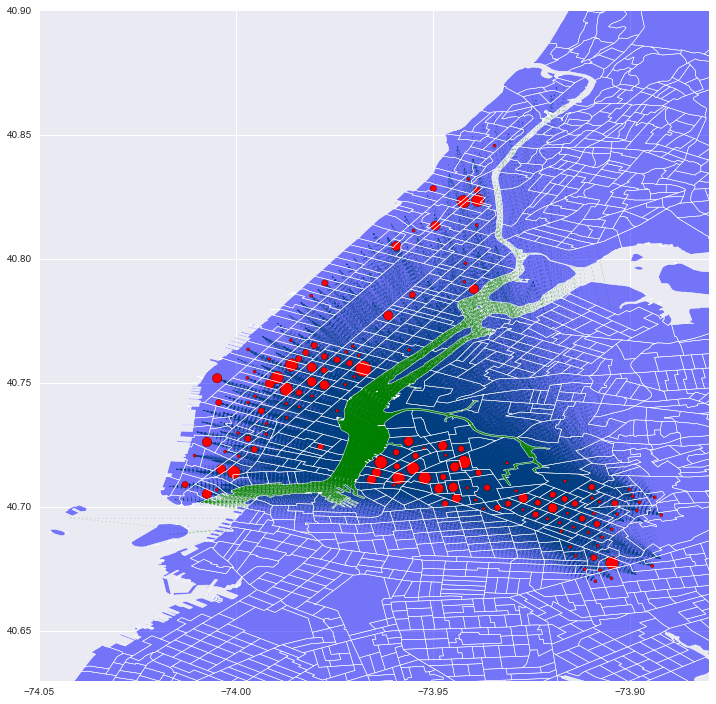

In [25]:
f, ax = pl.subplots(figsize=(12,12))

tracks.plot(c = 'white', linewidth = .5, ax = ax,  color= 'Blue')

nx.draw_networkx_nodes(G,pos=trackpos, ax=ax,node_size=[10*(v/387)**2 for v in trackdegree.values()])
nx.draw_networkx_edges(G,pos=trackpos, style='dotted',edge_color='green', ax=ax, width=.2)
#nx.draw(G,pos=trackpos,with_labels=False,arrows=True,node_size=15,style='dotted',edge_color='green')
#pl.axis('off')
pl.ylim(40.63, 40.90)
pl.xlim(-74.05, -73.88)
#pl.title("World Trade", size=20)
pl.savefig('test2.png',bbox_inches="tight")

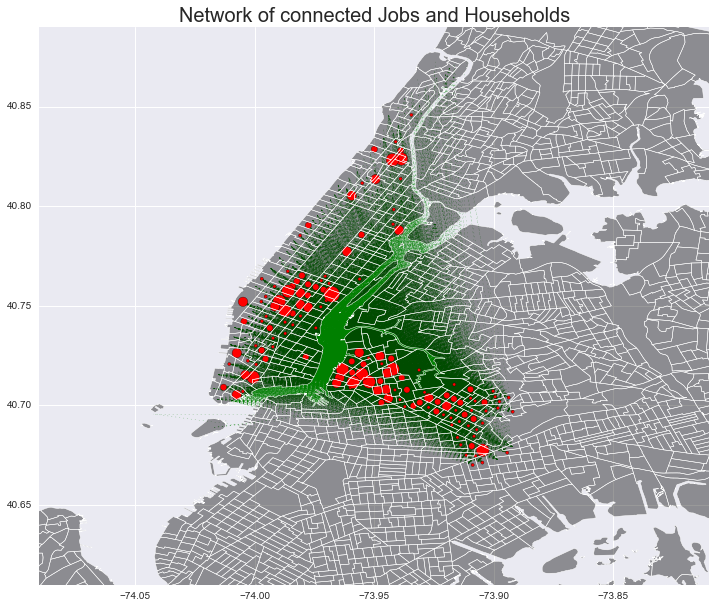

In [26]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap    
mycolor = ListedColormap('k')



f, ax = pl.subplots(figsize=(12,10))

#f.patch.set_facecolor('silver')
#f(fill_color='aqua')
tracks.plot(c = 'white', linewidth = .5, ax = ax, cmap=mycolor, alpha=.4)

#nx.draw(G,pos=trackpos,with_labels=False,arrows=True,node_size=15,style='dotted',edge_color='green', ax=ax)
nx.draw_networkx_nodes(G,pos=trackpos, ax=ax,node_size=[10*(v/387)**2 for v in trackdegree.values()])
nx.draw_networkx_edges(G,pos=trackpos, style='dotted',edge_color='green', ax=ax, width=.2)
#    nx.draw_networkx_labels(graph,pos)



pl.ylim(40.61, 40.89)
pl.xlim(-74.09, -73.81)
#pl.legend()

#pl.axis('off')
#pl.legend()
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Network of connected Jobs and Households", size=20)
pl.savefig('test.png',bbox_inches="tight")

In [27]:
fileUrl = 'https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=GeoJSON'
filebuffer = urllib.urlretrieve(fileUrl, filename='Subway Lines.geojson')
fname = 'Subway Lines.geojson'
print (fname)
subline = gpd.GeoDataFrame.from_file('Subway Lines.geojson')
subline.crs = from_epsg(4326) #= from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

Subway Lines.geojson


In [28]:
subline['color']='NONE'
subline['color'][subline['name']=='G'] = 'greenyellow'
subline['color'][subline['name']=='N'] = 'y'
subline['color'][subline['name']=='R'] = 'y'
subline['color'][subline['name']=='N-Q-R'] = 'y'
subline['color'][subline['name']=='N-Q-R-W'] = 'y'
subline['color'][subline['name']=='N-R-W'] = 'y'
subline['color'][subline['name']=='N-Q'] = 'y'
subline['color'][subline['name']=='N-R'] = 'y'
subline['color'][subline['name']=='N-W'] = 'y'
subline['color'][subline['name']=='R-W'] = 'y'
subline['color'][subline['name']=='Q'] = 'y'
subline['color'][subline['name']=='B'] = 'orange'
subline['color'][subline['name']=='M'] = 'orange'
subline['color'][subline['name']=='B-D'] = 'orange'
subline['color'][subline['name']=='B-D-F-M'] = 'orange'
subline['color'][subline['name']=='F-M'] = 'orange'
subline['color'][subline['name']=='F'] = 'orange'
subline['color'][subline['name']=='D'] = 'orange'
subline['color'][subline['name']=='A'] = 'blue'
subline['color'][subline['name']=='C'] = 'blue'
subline['color'][subline['name']=='A-C'] = 'blue'
subline['color'][subline['name']=='A-C-E'] = 'blue'
subline['color'][subline['name']=='E'] = 'blue'
subline['color'][subline['name']=='S'] = 'dimgrey'
subline['color'][subline['name']=='7'] = 'm'
subline['color'][subline['name']=='1-2-3'] = 'r'
subline['color'][subline['name']=='2-3'] = 'r'
subline['color'][subline['name']=='2'] = 'r'
subline['color'][subline['name']=='1'] = 'r'
subline['color'][subline['name']=='3'] = 'r'
subline['color'][subline['name']=='J-Z'] = 'saddlebrown'
subline['color'][subline['name']=='L'] = 'darkgrey'
subline['color'][subline['name']=='4-5-6'] = 'green'
subline['color'][subline['name']=='4-5'] = 'green'
subline['color'][subline['name']=='5'] = 'green'
subline['color'][subline['name']=='6'] = 'green'
subline['color'][subline['name']=='4'] = 'green'

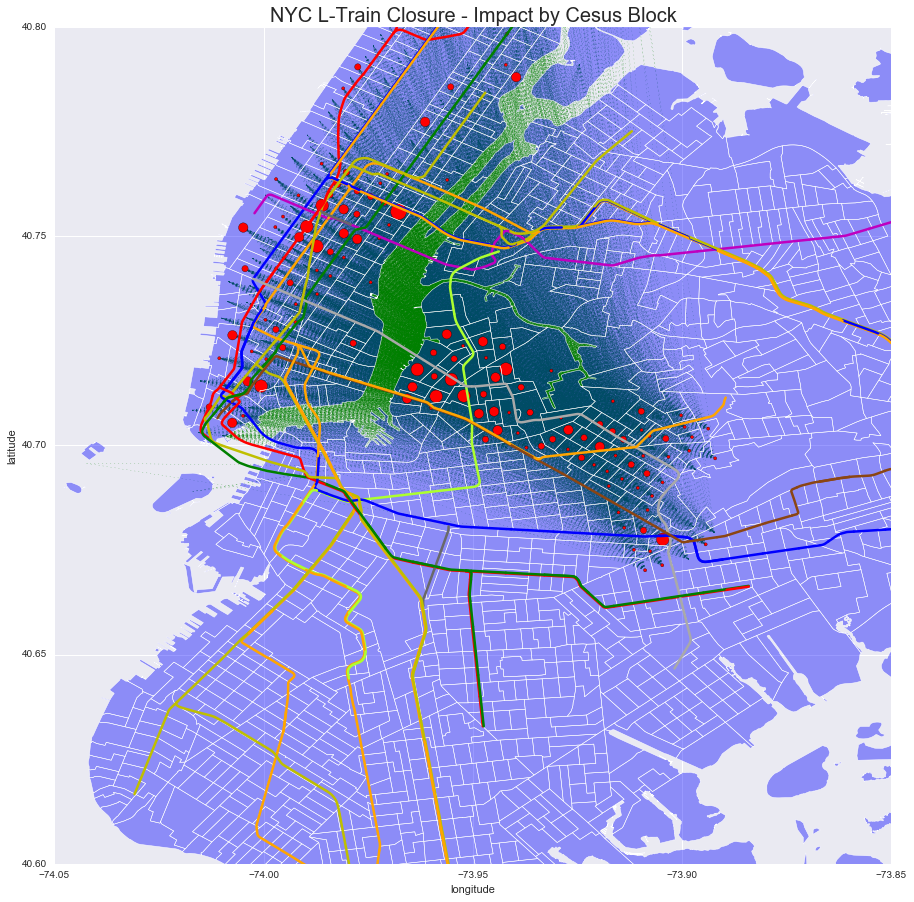

In [30]:
colors = ['skyblue','goldenrod']
mycolor = ListedColormap('b')
f, ax = pl.subplots(figsize=(15,15))
#NYCshape.plot(linewidth = 0.5, color = 'k', ax = ax,alpha=.9, cmap='k')
tracks.plot(c = 'white', linewidth = .5, ax = ax, cmap=mycolor, alpha=.4)

#nx.draw(G,pos=trackpos,with_labels=False,arrows=True,node_size=15,style='dotted',edge_color='green', ax=ax)
nx.draw_networkx_nodes(G,pos=trackpos, ax=ax,node_size=[10*(v/387)**2 for v in trackdegree.values()])
nx.draw_networkx_edges(G,pos=trackpos, style='dotted',edge_color='green', ax=ax, width=.2)
#CensusBlocks[CensusBlocks.Within30min==True].plot(linewidth = 0.1, color = 'goldenrod', ax = ax, alpha=.5, label='30min Walking Distance')
#CensusBlocks[CensusBlocks.Within15min==True].plot(linewidth = 0.1, color = 'skyblue', ax = ax, alpha=.7, label='15min Walking Distance')
for i in range(len(subline)):
    #print i
    colocin=subline.color.iloc[i]
    subline.iloc[i:i+1].plot(linewidth = 2.5, color = colocin , ax = ax)
#subStations.plot(marker='o', markersize=5, linewidth = 4, color = 'w', ax = ax)

pl.xlabel('longitude')
pl.ylabel('latitude')
pl.legend()
pl.ylim(40.6, 40.8)
pl.xlim(-74.05, -73.85)
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("NYC L-Train Closure - Impact by Cesus Block", size=20)